# CS 363D Final Project: Predicting Adoption in Austin Animal Center

#### Mrityunjay Mishra, Rohit Neppalli, Ziyi Zhao, Justin Leong 

## Project Description

Many different types of animals (from dogs to livestock) are taken in by the Austin Animal Center each year for various reasons. Some may be adopted, some may be transferred, and some may even go through Euthanasia. The goal of this project is to predict if an animal that is taken in by the Austin Animal Center will be adopted or not. This can have good applications for Austin Animal Center - they could use our findings to predict the probability of adoption for an animal that is taken in and can care for it accordingly. Or perhaps someone else can use our findings to find animals who have a low probability of adoption to care for them accordingly. In the end, we hope that our findings provide insight into the adoption patterns of Austin and, consequently, helps different organizations take care of these animal appropriately.

In [1]:
# importing headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

## Dataset

To develop our classifier(s), we use the animal intake and outcome data from the open data portal of the city of Austin. To find out more about the animal intake data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm). To find out more about the outcome data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In [2]:
# Intakes data
intakes_df = pd.read_csv('Austin_Animal_Center_Intakes.csv')
intakes_df.head()

Animal ID     Name                DateTime     MonthYear  \
0   A786884   *Brock  01/03/2019 04:19:00 PM  January 2019   
1   A706918    Belle  07/05/2015 12:59:00 PM     July 2015   
2   A724273  Runster  04/14/2016 06:43:00 PM    April 2016   
3   A665644      NaN  10/21/2013 07:59:00 AM  October 2013   
4   A682524      Rio  06/29/2014 10:38:00 AM     June 2014   

                        Found Location Intake Type Intake Condition  \
0  2501 Magin Meadow Dr in Austin (TX)       Stray           Normal   
1     9409 Bluegrass Dr in Austin (TX)       Stray           Normal   
2   2818 Palomino Trail in Austin (TX)       Stray           Normal   
3                          Austin (TX)       Stray             Sick   
4        800 Grove Blvd in Austin (TX)       Stray           Normal   

  Animal Type Sex upon Intake Age upon Intake  \
0         Dog   Neutered Male         2 years   
1         Dog   Spayed Female         8 years   
2         Dog     Intact Male       11 months   
3         Cat   Intact Female         4 weeks   
4         Dog   Neutered Male         4 years   

                                   Breed        Color  
0                             Beagle Mix     Tricolor  
1               English Springer Spaniel  White/Liver  
2                            Basenji Mix  Sable/White  
3                 Domestic Shorthair Mix       Calico  
4  Doberman Pinsch/Australian Cattle Dog     Tan/Gray

In [3]:
# Outcomes data
outcomes_df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
outcomes_df.head()

Animal ID   Name                DateTime MonthYear Date of Birth  \
0   A794011  Chunk  05/08/2019 06:20:00 PM  May 2019    05/02/2017   
1   A776359  Gizmo  07/18/2018 04:02:00 PM  Jul 2018    07/12/2017   
2   A821648    NaN  08/16/2020 11:38:00 AM  Aug 2020    08/16/2019   
3   A720371  Moose  02/13/2016 05:59:00 PM  Feb 2016    10/08/2015   
4   A674754    NaN  03/18/2014 11:47:00 AM  Mar 2014    03/12/2014   

  Outcome Type Outcome Subtype Animal Type Sex upon Outcome Age upon Outcome  \
0    Rto-Adopt             NaN         Cat    Neutered Male          2 years   
1     Adoption             NaN         Dog    Neutered Male           1 year   
2   Euthanasia             NaN       Other          Unknown           1 year   
3     Adoption             NaN         Dog    Neutered Male         4 months   
4     Transfer         Partner         Cat      Intact Male           6 days   

                                Breed              Color  
0              Domestic Shorthair Mix  Brown Tabby/White  
1             Chihuahua Shorthair Mix        White/Brown  
2                             Raccoon               Gray  
3  Anatol Shepherd/Labrador Retriever               Buff  
4              Domestic Shorthair Mix       Orange Tabby

## Data Cleaning

We can immedietly see that we must combine both `intakes_df` and `outcomes_df` on `Animal ID`. We will first explore and clean both `intakes_df` and `outcomes_df` and combine them in the end.

### Feature Selection

`Name`, `DateTime`, `MonthYear`, and `Found Location` can immedietly be dropped from `intakes_df` because these features will not have be be relevant to determining if an animal will be adopted or not. The name of the animal could be changed after adoption; `DateTime` and `MonthYear` are related to `Age upon Intake` and thus irrelevant (because age is more important than the exact date etc.); and `Found Location` is also irrelevant in adoption matters. 

We may think that `Intake Type` can also be dropped. However, it actually has some useful values that may determine adoption or not. 

In [4]:
intakes_df['Intake Type'].unique()

array(['Stray', 'Owner Surrender', 'Public Assist', 'Wildlife',
       'Euthanasia Request', 'Abandoned'], dtype=object)

Clearly, if an animal is taken into Austin Animal Center on a Euthanasia Request, then its chances for being adopted become drastically low. Other reasons for intake can also play a part in adoption considerations. Therefore, we do not drop `Intake Type` (in fact, we will see later that `Intake Type` becomes crucial to building our classifiers). The final columns that are dropped from `intakes_df` are `Name`, `DateTime`, `MonthYear`, `Found Location`.

In [5]:
intakes_df = intakes_df.drop(columns=['Name', 'DateTime', 'MonthYear', 'Found Location'])
intakes_df.head()

Animal ID Intake Type Intake Condition Animal Type Sex upon Intake  \
0   A786884       Stray           Normal         Dog   Neutered Male   
1   A706918       Stray           Normal         Dog   Spayed Female   
2   A724273       Stray           Normal         Dog     Intact Male   
3   A665644       Stray             Sick         Cat   Intact Female   
4   A682524       Stray           Normal         Dog   Neutered Male   

  Age upon Intake                                  Breed        Color  
0         2 years                             Beagle Mix     Tricolor  
1         8 years               English Springer Spaniel  White/Liver  
2       11 months                            Basenji Mix  Sable/White  
3         4 weeks                 Domestic Shorthair Mix       Calico  
4         4 years  Doberman Pinsch/Australian Cattle Dog     Tan/Gray

Similarly, `Name`, `DateTime`, `Date of Birth`, and `Outcome Subtype` can immedietly be dropped from `outcomes_df` because there features will not be relevant to classification. Once again, `Name` is clearly irrelevant; the `DateTime` of the outcome makes no difference as to what the outcome is; the `Date of Birth` of the animal is related to its `Age upon Outcome` and thus is not important; and we are not interested in `Outcome Subtype` at the moment. We decided to keep `MonthYear` because it is possible that animals (or some types of animals) are adopted more at certain times of the year (e.x. Christmas) than others. `outcomes_ds` after removing these features is as follows.

In [6]:
outcomes_df = outcomes_df.drop(columns=['Name', 'DateTime', 'Date of Birth', 'Outcome Subtype'])
outcomes_df.head()

Animal ID MonthYear Outcome Type Animal Type Sex upon Outcome  \
0   A794011  May 2019    Rto-Adopt         Cat    Neutered Male   
1   A776359  Jul 2018     Adoption         Dog    Neutered Male   
2   A821648  Aug 2020   Euthanasia       Other          Unknown   
3   A720371  Feb 2016     Adoption         Dog    Neutered Male   
4   A674754  Mar 2014     Transfer         Cat      Intact Male   

  Age upon Outcome                               Breed              Color  
0          2 years              Domestic Shorthair Mix  Brown Tabby/White  
1           1 year             Chihuahua Shorthair Mix        White/Brown  
2           1 year                             Raccoon               Gray  
3         4 months  Anatol Shepherd/Labrador Retriever               Buff  
4           6 days              Domestic Shorthair Mix       Orange Tabby

### Removing missing and erroneous values

As can be seen below, some values are missing from some rows in both `intakes_df` and `outcomes_df`. However, this is not a significant number of rows, so we just drop these rows. 

In [7]:
# Notice that the total row count per feature in both intakes_df 
# and outcomes_df is not the same, indicating that some values 
# are missing from the both datasets
print('Total number of rows in intakes_df: {:d}\n'.format(intakes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in intakes_df')
print(intakes_df.count()) 

print('\nTotal number of rows in intakes_df: {:d}\n'.format(outcomes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in outcomes_df')
print(outcomes_df.count()) 

Total number of rows in intakes_df: 138350

Number of non-NaN rows (or rows without missing values in general) in intakes_df
Animal ID           138350
Intake Type         138350
Intake Condition    138350
Animal Type         138350
Sex upon Intake     138349
Age upon Intake     138350
Breed               138350
Color               138350
dtype: int64

Total number of rows in intakes_df: 138565

Number of non-NaN rows (or rows without missing values in general) in outcomes_df
Animal ID           138565
MonthYear           138565
Outcome Type        138542
Animal Type         138565
Sex upon Outcome    138564
Age upon Outcome    138559
Breed               138565
Color               138565
dtype: int64


In [8]:
intakes_df.dropna(inplace=True)
outcomes_df.dropna(inplace=True)

We also notice that there are some erroneous values for `Age upon Intake` and `Age upon Outcome` in the `intakes_df` and `outcomes_df`. Thus, we drop these rows (we do not try to rectify such values so as to not skew the data or introduce any other type of bias).

In [9]:
print('Unique values of Age upon Intake')
print(intakes_df['Age upon Intake'].unique())
print()
print('Unique values of Age upon Outcome')
print(outcomes_df['Age upon Outcome'].unique())

Unique values of Age upon Intake
['2 years' '8 years' '11 months' '4 weeks' '4 years' '6 years' '6 months'
 '5 months' '14 years' '1 month' '2 months' '18 years' '9 years'
 '4 months' '1 year' '3 years' '4 days' '1 day' '5 years' '2 weeks'
 '15 years' '7 years' '3 weeks' '3 months' '12 years' '1 week' '9 months'
 '10 years' '10 months' '7 months' '8 months' '1 weeks' '5 days' '0 years'
 '2 days' '11 years' '17 years' '3 days' '13 years' '5 weeks' '19 years'
 '6 days' '16 years' '20 years' '-1 years' '22 years' '23 years'
 '-2 years' '21 years' '-3 years' '25 years' '24 years' '30 years'
 '28 years']

Unique values of Age upon Outcome
['2 years' '1 year' '4 months' '6 days' '7 years' '2 months' '2 days'
 '3 weeks' '9 months' '4 weeks' '2 weeks' '3 months' '9 years' '10 years'
 '6 months' '8 years' '3 years' '7 months' '6 years' '4 years' '1 month'
 '12 years' '5 years' '1 weeks' '5 months' '5 days' '15 years' '11 months'
 '10 months' '4 days' '16 years' '1 day' '8 months' '11 years' '13

In [10]:
# Dropping erroneous values in intakes_df
indices = (intakes_df['Age upon Intake'] == '0 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-1 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-2 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-3 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)

# Dropping erroneous values in outcomes_df
indices = (outcomes_df['Age upon Outcome'] == '0 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-1 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-2 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-3 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)

print('Unique values of Age upon Intake')
print(intakes_df['Age upon Intake'].unique())
print()
print('Unique values of Age upon Outcome')
print(outcomes_df['Age upon Outcome'].unique())

Unique values of Age upon Intake
['2 years' '8 years' '11 months' '4 weeks' '4 years' '6 years' '6 months'
 '5 months' '14 years' '1 month' '2 months' '18 years' '9 years'
 '4 months' '1 year' '3 years' '4 days' '1 day' '5 years' '2 weeks'
 '15 years' '7 years' '3 weeks' '3 months' '12 years' '1 week' '9 months'
 '10 years' '10 months' '7 months' '8 months' '1 weeks' '5 days' '2 days'
 '11 years' '17 years' '3 days' '13 years' '5 weeks' '19 years' '6 days'
 '16 years' '20 years' '22 years' '23 years' '21 years' '25 years'
 '24 years' '30 years' '28 years']

Unique values of Age upon Outcome
['2 years' '1 year' '4 months' '6 days' '7 years' '2 months' '2 days'
 '3 weeks' '9 months' '4 weeks' '2 weeks' '3 months' '9 years' '10 years'
 '6 months' '8 years' '3 years' '7 months' '6 years' '4 years' '1 month'
 '12 years' '5 years' '1 weeks' '5 months' '5 days' '15 years' '11 months'
 '10 months' '4 days' '16 years' '1 day' '8 months' '11 years' '13 years'
 '1 week' '14 years' '3 days' '5 wee

The same can be noticed for `Sex upon intake` and `Sex upon Outcome` for both `intakes_df` and `outcomes_df`. Both have values of `Unknown` which, while it may not be fully erroneous, is not very useful. Hence, we drop all rows with these values as well. Note that this will not impact us in the long run since we have quite a large amount of data to work with. 

In [11]:
print('Unique values of Sex upon Intake in intakes_df')
print(intakes_df['Sex upon Intake'].unique())
print()
print('Unique values of Sex upon Outcome in outcomes_df')
print(outcomes_df['Sex upon Outcome'].unique())

Unique values of Sex upon Intake in intakes_df
['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown']

Unique values of Sex upon Outcome in outcomes_df
['Neutered Male' 'Unknown' 'Intact Male' 'Spayed Female' 'Intact Female']


In [12]:
# Dropping erroneous values in intakes_df
indices = (intakes_df['Sex upon Intake'] == 'Unknown')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)

# Dropping erroneous values in outcomes_df
indices = (outcomes_df['Sex upon Outcome'] == 'Unknown')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)

print('Unique values of Sex upon Intake in intakes_df')
print(intakes_df['Sex upon Intake'].unique())
print()
print('Unique values of Sex upon Outcome in outcomes_df')
print(outcomes_df['Sex upon Outcome'].unique())

Unique values of Sex upon Intake in intakes_df
['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female']

Unique values of Sex upon Outcome in outcomes_df
['Neutered Male' 'Intact Male' 'Spayed Female' 'Intact Female']


### Removing Duplicates

A number of the animals come in and go out of the animal center multiple times, and we can see that when comparing the number of unique animal id's to the number of total records for both datasets. This causes many duplicates in our dataset. Since we have so much data, we will consider only the animals that have completely unique records in the dataframes for simplicity's sake

In [13]:
print(len(intakes_df['Animal ID'].unique()))
print(len(intakes_df['Animal ID']))
print(len(outcomes_df['Animal ID'].unique()))
print(len(outcomes_df['Animal ID']))

112006
126625
112779
127422


In [14]:
intakes_df = intakes_df.drop_duplicates(subset=['Animal ID'])
outcomes_df = outcomes_df.drop_duplicates(subset=['Animal ID'])

In [15]:
# Make a copy of the cleaned, original dataset for future use
intakes_original = intakes_df.copy()
outcomes_original = outcomes_df.copy()

## Data Exploration

Let us first explore the both the intakes and the outcomes data and better understand what they mean before feature engineering and model creation. This will help us make informed choices in the future during these steps and will also give us more insight into useful adoption patterns. 

### Overarching Trends

#### Intakes Data

Text(0, 0.5, 'Distribution')

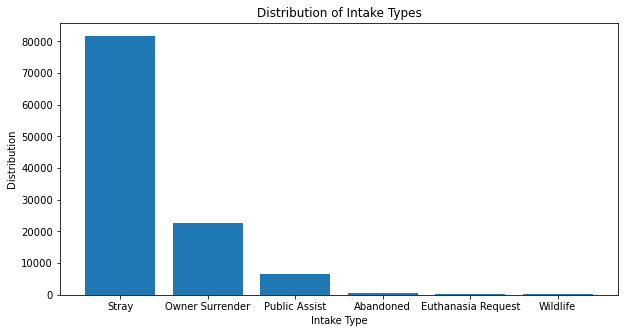

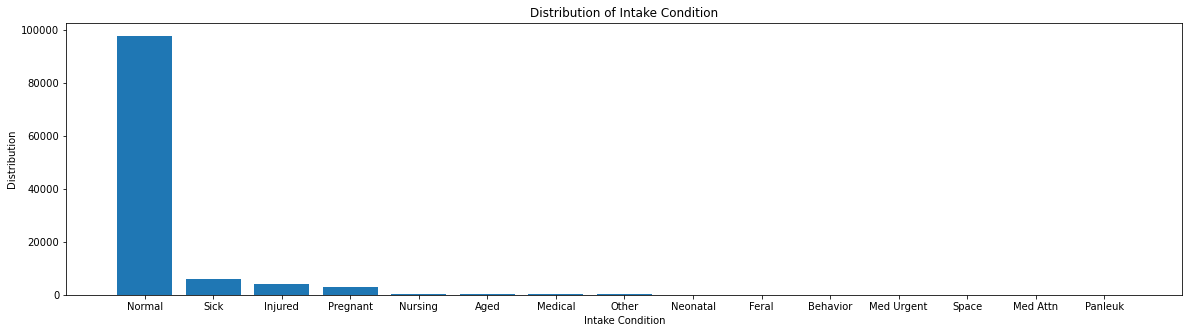

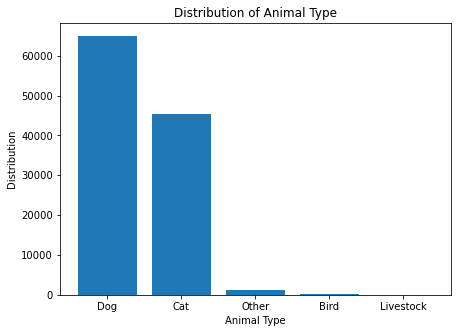

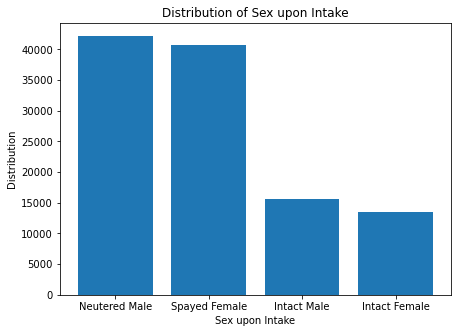

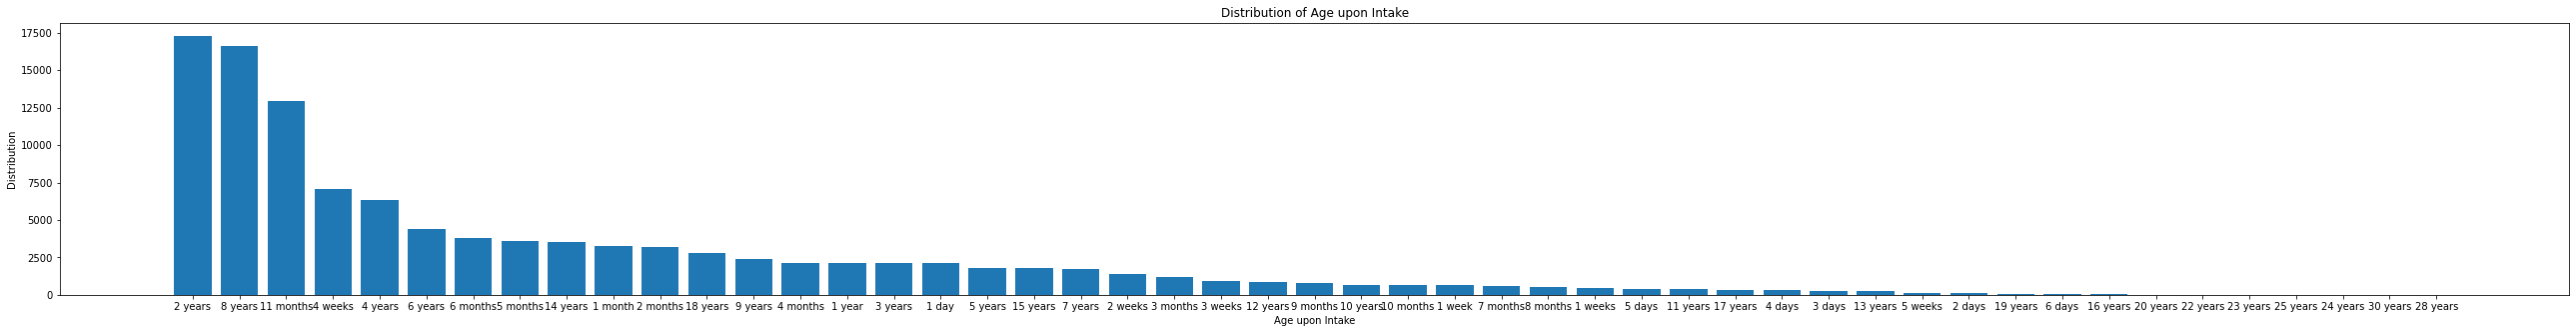

In [16]:
# Intake Type
fig = plt.figure(figsize = (10, 5)) 
plt.bar(intakes_df['Intake Type'].unique(), intakes_df['Intake Type'].value_counts().values)
plt.title('Distribution of Intake Types')
plt.xlabel('Intake Type')
plt.ylabel('Distribution')

# Intake Condition
fig = plt.figure(figsize = (20, 5)) 
plt.bar(intakes_df['Intake Condition'].unique(), intakes_df['Intake Condition'].value_counts().values)
plt.title('Distribution of Intake Condition')
plt.xlabel('Intake Condition')
plt.ylabel('Distribution')

# Animal Type
fig = plt.figure(figsize = (7, 5)) 
plt.bar(intakes_df['Animal Type'].unique(), intakes_df['Animal Type'].value_counts().values)
plt.title('Distribution of Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Distribution')

# Sex upon Intake
fig = plt.figure(figsize = (7, 5)) 
plt.bar(intakes_df['Sex upon Intake'].unique(), intakes_df['Sex upon Intake'].value_counts().values)
plt.title('Distribution of Sex upon Intake')
plt.xlabel('Sex upon Intake')
plt.ylabel('Distribution')

# Age upon Intake
fig = plt.figure(figsize = (45, 5)) 
plt.bar(intakes_df['Age upon Intake'].unique(), intakes_df['Age upon Intake'].value_counts().values)
plt.title('Distribution of Age upon Intake')
plt.xlabel('Age upon Intake')
plt.ylabel('Distribution')

In [17]:
# Showing value counts only for these features because a bar graph
# was not legible due to the availability of multitudes of values per feature
print('Value counts of Breed')
print(intakes_df['Breed'].value_counts())
print()
print('Value counts of Color')
print(intakes_df['Color'].value_counts())

Value counts of Breed
Domestic Shorthair Mix               27432
Domestic Shorthair                    9675
Pit Bull Mix                          6786
Labrador Retriever Mix                6132
Chihuahua Shorthair Mix               5723
                                     ...  
Border Collie/English Pointer            1
Akita/Pit Bull                           1
German Shorthair Pointer/Brittany        1
Chihuahua Shorthair/Cirneco              1
Munchkin Longhair                        1
Name: Breed, Length: 2669, dtype: int64

Value counts of Color
Black/White          11774
Black                 9389
Brown Tabby           6871
White                 4062
Brown/White           3763
                     ...  
Brown Merle/Gray         1
Tricolor/Orange          1
Calico/Gray Tabby        1
Lynx Point/Blue          1
Brown Tabby/Tan          1
Name: Color, Length: 594, dtype: int64


#### Outcomes Data

Text(0, 0.5, 'Distribution')

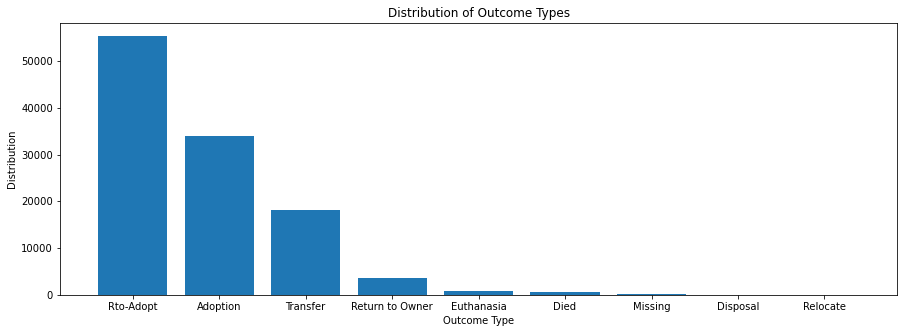

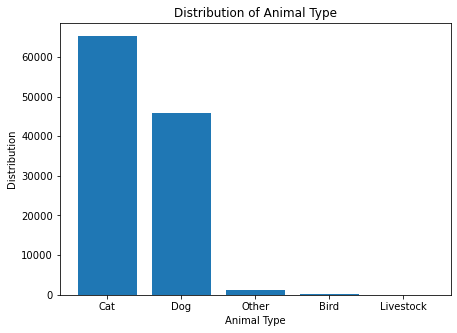

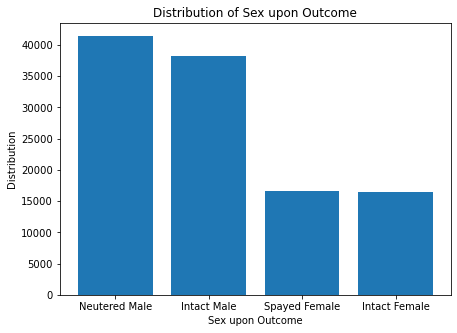

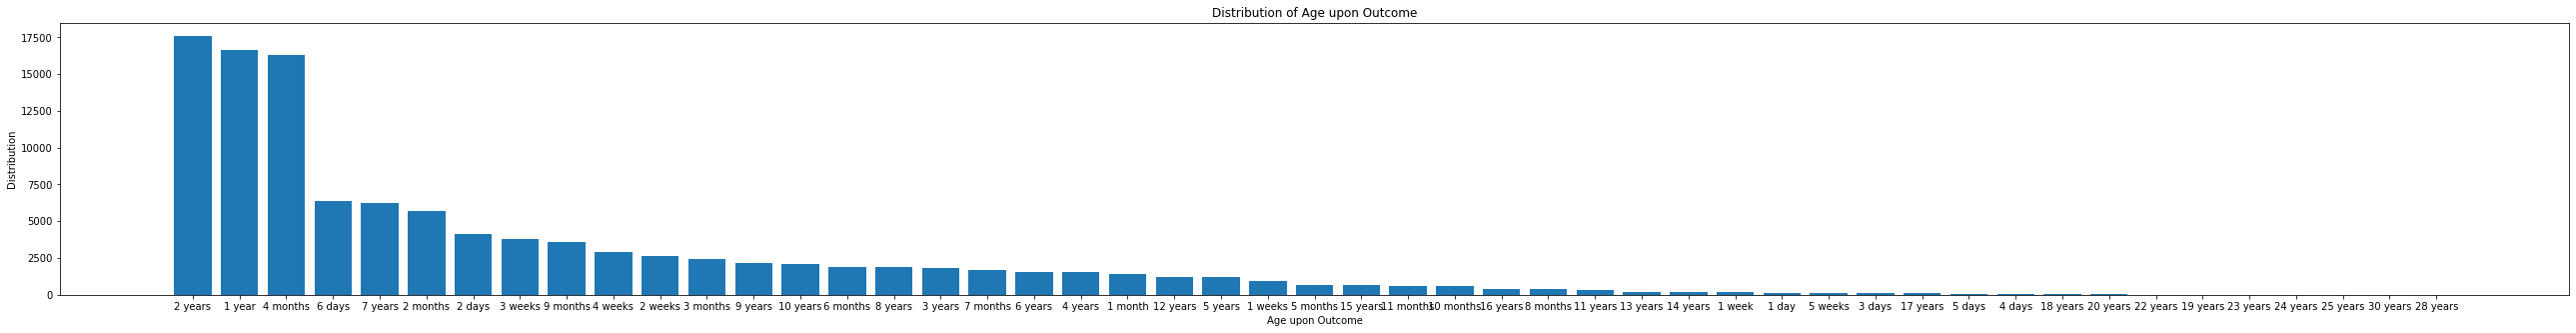

In [18]:
# Outcome Type
fig = plt.figure(figsize = (15, 5)) 
plt.bar(outcomes_df['Outcome Type'].unique(), outcomes_df['Outcome Type'].value_counts().values)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type')
plt.ylabel('Distribution')

# Animal Type
fig = plt.figure(figsize = (7, 5)) 
plt.bar(outcomes_df['Animal Type'].unique(), outcomes_df['Animal Type'].value_counts().values)
plt.title('Distribution of Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Distribution')

# Sex upon Outcome
fig = plt.figure(figsize = (7, 5)) 
plt.bar(outcomes_df['Sex upon Outcome'].unique(), outcomes_df['Sex upon Outcome'].value_counts().values)
plt.title('Distribution of Sex upon Outcome')
plt.xlabel('Sex upon Outcome')
plt.ylabel('Distribution')

# Age upon Outcome
fig = plt.figure(figsize = (45, 5)) 
plt.bar(outcomes_df['Age upon Outcome'].unique(), outcomes_df['Age upon Outcome'].value_counts().values)
plt.title('Distribution of Age upon Outcome')
plt.xlabel('Age upon Outcome')
plt.ylabel('Distribution')

In [19]:
# Showing value counts only for these features because a bar graph
# was not legible due to the availability of multitudes of values per feature
print('Value counts of Breed')
print(outcomes_df['Breed'].value_counts())
print()
print('Value counts of Color')
print(outcomes_df['Color'].value_counts())

Value counts of Breed
Domestic Shorthair Mix              27893
Domestic Shorthair                   9603
Pit Bull Mix                         6848
Labrador Retriever Mix               6182
Chihuahua Shorthair Mix              5799
                                    ...  
Bullmastiff/Boxer                       1
Rat Terrier/English Pointer             1
Norwegian Elkhound/Alaskan Husky        1
Shih Tzu/Cavalier Span                  1
Munchkin Longhair                       1
Name: Breed, Length: 2679, dtype: int64

Value counts of Color
Black/White        11886
Black               9494
Brown Tabby         6923
White               4086
Brown/White         3784
                   ...  
Blue Tabby/Buff        1
Chocolate/Gold         1
Torbie/Calico          1
Yellow/Red             1
Orange/Tricolor        1
Name: Color, Length: 598, dtype: int64


### Analysis

We can see that there are many reasons an animal may be taken into Austin Animal Center along with many intake conditions etc. Dogs and cats are the most common types of animals taken in, with the most common reason for intake being stray, surrendered by their owner, or a public assist. Most animals are taken in normal conditions. Many are neutered or spayed. 

Given these trends, we formulate the following hypotheses:

- The type of animal plays a role into whether an animal will be adopted or not
- Age plays a role into whether an animal will be adopted or not
- Breed plays a role into whether an animal will be adopted or not
- Color plays a role into whether an animal will be adopted or not
- The health (i.e. the intake condition) of an animal will play a role into whether that animal will be adopted or not

We now analyze these relationships and test our hypotheses. Please note that we explicitly focus on the outcome of adoption only, even though there are other outcomes possible, for the purposes of data exploration. This is done in the interest of space and cociseness, and also because our main focus is to predict whether an animal will be adopted or not. 

_Note: we present the analysis for both Adoption and Rto-Adoption separately for clarity. However, it should be kept in mind that both are a form of adoption. Rto-Adoption is simply the case where the animal goes back to its original owners_

#### Relation of Animal Type and Adoption

In [20]:
df_adoption = outcomes_df[outcomes_df['Outcome Type'] == 'Adoption']
df_rto_adoption = outcomes_df[outcomes_df['Outcome Type'] == 'Rto-Adopt']

Text(0, 0.5, 'Ratio')

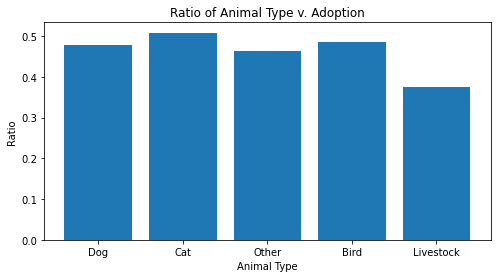

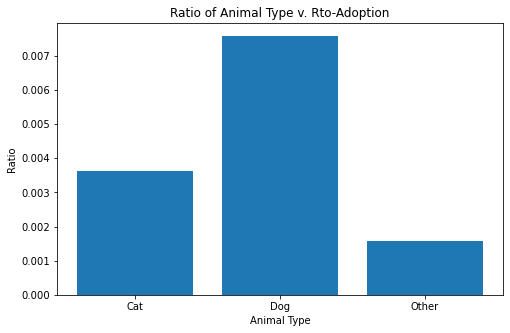

In [21]:
fig = plt.figure(figsize = (8, 4)) 
vals = df_adoption['Animal Type'].value_counts() / outcomes_df['Animal Type'].value_counts()
plt.bar(df_adoption['Animal Type'].unique(), vals.values)
plt.title('Ratio of Animal Type v. Adoption')
plt.xlabel('Animal Type')
plt.ylabel('Ratio')

fig = plt.figure(figsize = (8, 5)) 
vals = (df_rto_adoption['Animal Type'].value_counts() / outcomes_df['Animal Type'].value_counts()).dropna()
plt.bar(df_rto_adoption['Animal Type'].unique(), vals.values)
plt.title('Ratio of Animal Type v. Rto-Adoption')
plt.xlabel('Animal Type')
plt.ylabel('Ratio')

The type of animal plays a role to some degree into whether the animal will be adopted or not. It seems that cats have a slighlty higher chance than dogs to be adopted. However, their chances signiicantly reduce when it comes down to Rto-Adoption. Birds and dogs have about the same chance of being adopted. Note, however, that Birds have no change of being Rto-Adopt since they did not even show up in the second graph (this is likely a bias in the data, however). The same is true for Livestock. Livestock also have a significantly lower chance of being adopted. 

#### Relation of Age and Adoption

Text(0, 0.5, 'Ratio')

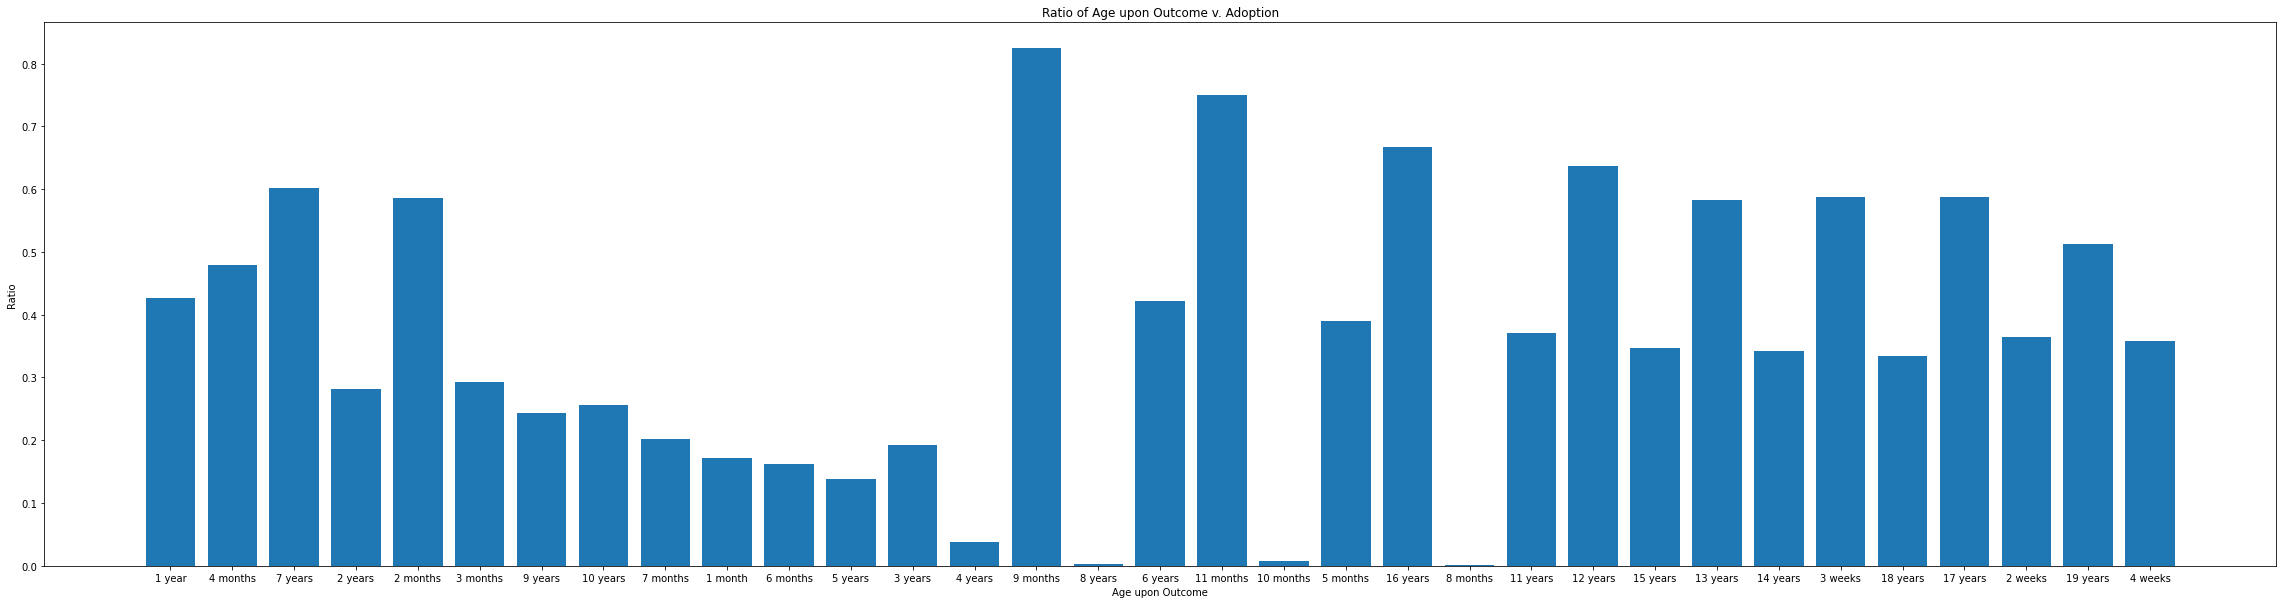

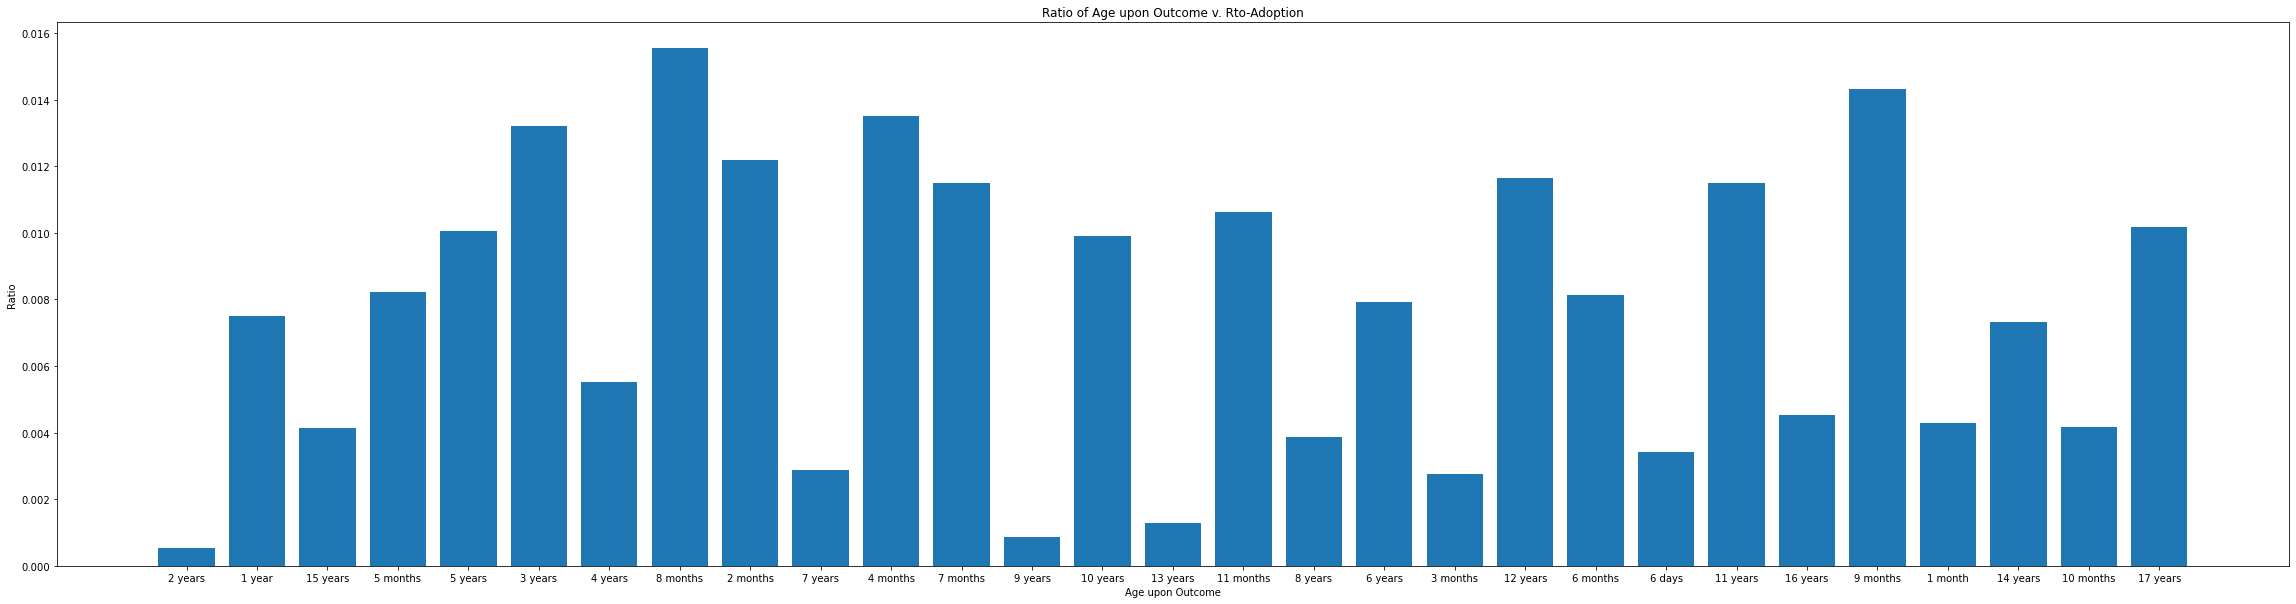

In [22]:
# TODO sort by age and then graph to get an actual trend
fig = plt.figure(figsize = (40, 10)) 
vals = (df_adoption['Age upon Outcome'].value_counts() / outcomes_df['Age upon Outcome'].value_counts()).dropna()
plt.bar(df_adoption['Age upon Outcome'].unique(), vals.values)
plt.title('Ratio of Age upon Outcome v. Adoption')
plt.xlabel('Age upon Outcome')
plt.ylabel('Ratio')

fig = plt.figure(figsize = (40, 10)) 
vals = (df_rto_adoption['Age upon Outcome'].value_counts() / outcomes_df['Age upon Outcome'].value_counts()).dropna()
plt.bar(df_rto_adoption['Age upon Outcome'].unique(), vals.values)
plt.title('Ratio of Age upon Outcome v. Rto-Adoption')
plt.xlabel('Age upon Outcome')
plt.ylabel('Ratio')

#### Relation of Breed and Adoption

In [23]:
vals = (df_adoption['Breed'].value_counts() / outcomes_df['Breed'].value_counts()).dropna()
print('Ratio of Breed v. Adoption')
print(vals)
print()
vals = (df_rto_adoption['Breed'].value_counts() / outcomes_df['Breed'].value_counts()).dropna()
print('Ratio of Breed v. Rto-Adoption')
print(vals)

Ratio of Breed v. Adoption
Abyssinian                                       0.571429
Abyssinian Mix                                   0.600000
Affenpinscher                                    1.000000
Affenpinscher Mix                                0.571429
Afghan Hound/Labrador Retriever                  1.000000
                                                   ...   
Yorkshire Terrier/Shih Tzu                       0.666667
Yorkshire Terrier/Soft Coated Wheaten Terrier    1.000000
Yorkshire Terrier/Standard Schnauzer             1.000000
Yorkshire Terrier/Toy Poodle                     0.363636
Yorkshire Terrier/Yorkshire Terrier              1.000000
Name: Breed, Length: 1936, dtype: float64

Ratio of Breed v. Rto-Adoption
Akita                                    0.050000
Akita Mix                                0.040000
Alaskan Husky                            0.023529
Alaskan Husky Mix                        0.024000
Alaskan Malamute                         0.055556
           

While we are not able to effectively display this data in a graph, a simple inspection of the ratios above clearly shows that the breed of an animal does play a role into its chances of being adopted or rto-adopted.

#### Relation of Color and Adoption

In [24]:
vals = (df_adoption['Color'].value_counts() / outcomes_df['Color'].value_counts()).dropna()
print('Ratio of Color v. Adoption')
print(vals)
print()
vals = (df_rto_adoption['Color'].value_counts() / outcomes_df['Color'].value_counts()).dropna()
print('Ratio of Color v. Rto-Adoption')
print(vals)

Ratio of Color v. Adoption
Agouti                0.625000
Agouti/Brown Tabby    1.000000
Agouti/Gray           1.000000
Agouti/White          0.666667
Apricot               0.452055
                        ...   
Yellow/Cream          1.000000
Yellow/Orange         0.500000
Yellow/Red            1.000000
Yellow/Tan            0.250000
Yellow/White          0.460432
Name: Color, Length: 454, dtype: float64

Ratio of Color v. Rto-Adoption
Apricot                 0.013699
Black                   0.004319
Black Smoke/Gray        1.000000
Black Smoke/White       0.020408
Black/Black             0.006944
                          ...   
White/Tan               0.007506
White/Tricolor          0.007380
White/White             0.020619
White/Yellow Brindle    0.166667
Yellow                  0.003241
Name: Color, Length: 96, dtype: float64


Once again, while we are not able to effectively display this data in a graph, a simple inspection of the ratios above clearly shows that the color of an animal does play a role into its chances of being adopted or rto-adopted.

#### Relation of Intake Condition (Health) and Adoption

To relate Intake Health with Adoption, we must first merge `intakes_df` and `outcomes_df`. Note that we will once again to this later after feature engineering. Thus, this merge is only for this analysis.

In [25]:
merged = intakes_df.merge(outcomes_df[[ 'Animal ID', 'MonthYear', 'Outcome Type', 'Animal Type', 'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color' ]], on='Animal ID')
merged_adoption = merged[merged['Outcome Type'] == 'Adoption']
merged_rto_adoption = merged[merged['Outcome Type'] == 'Rto-Adopt']

Text(0, 0.5, 'Ratio')

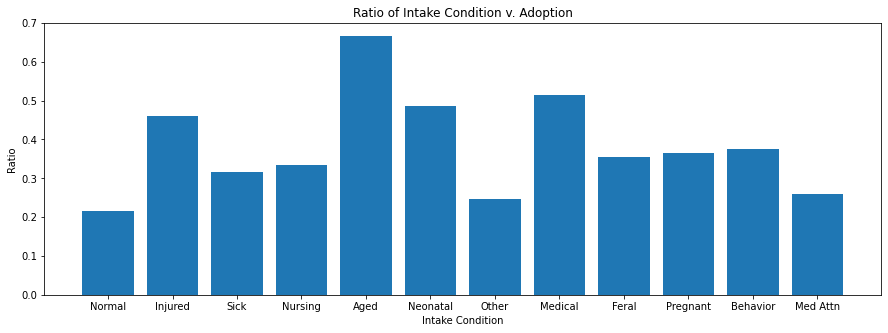

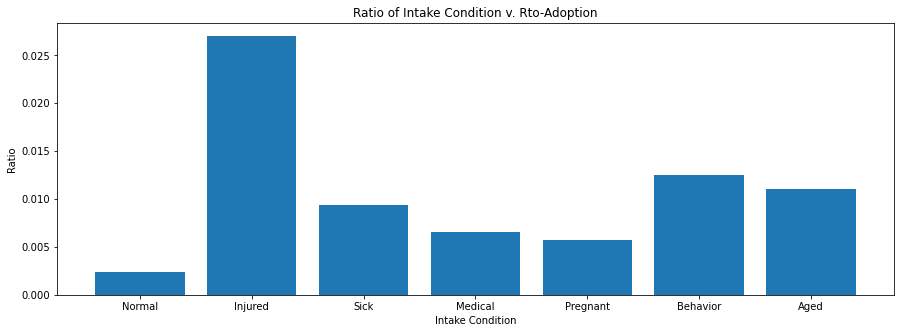

In [26]:
fig = plt.figure(figsize = (15, 5)) 
vals = (merged_adoption['Intake Condition'].value_counts() / merged['Intake Condition'].value_counts()).dropna()
plt.bar(merged_adoption['Intake Condition'].unique(), vals.values)
plt.title('Ratio of Intake Condition v. Adoption')
plt.xlabel('Intake Condition')
plt.ylabel('Ratio')

fig = plt.figure(figsize = (15, 5)) 
vals = (merged_rto_adoption['Intake Condition'].value_counts() / merged['Intake Condition'].value_counts()).dropna()
plt.bar(merged_rto_adoption['Intake Condition'].unique(), vals.values)
plt.title('Ratio of Intake Condition v. Rto-Adoption')
plt.xlabel('Intake Condition')
plt.ylabel('Ratio')

Observing the graphs above clearly shows that the intake health of an animal impacts its chances to get adopted or rto-adopted. However, finding an apparent patterns between the specific intake condition and chances of adoption (or rto-adoption) are much harder to discern. We will leave this task to the models that we will make later on.

### Final thoughts on data exploration

Our analyses above clearly show that features such as intake condition and age of an animal impacts its ability to get adopted or rto-adopted. Hence, the features analyzed above will be crucial as the input to our models.

It is important to note that adoption and rto-adoption are note the only possible outcomes. We did not analyze the relation of above features compared to other outcome types in the interest of conciseness - however, that is not to say that a relationship does not exist. Considering all potential outcomes is crucial to the applicability of our model(s). Therefore, from here on out, whenever we build our models, we will consider all outcome possibilities, not just adoption and rto-adoption. However, how to approach this problem of classification (multi-class classification, where our model automatically predicts from all the possible outcomes, or binary classification, where our model only predicts if a certain outcome, from the set of all possible outcomes, will happen or not) is still something that must be investigated. 

### Feature Engineering and Final Data Prep

From the output below, we see that all our data is currently an object type, or categorical. However, some features should be continuous while others should be categorical. We convert the appropriate features into continuousy variables first and then perform one hot encoding to the remaining categorical features.

In [27]:
print('intakes_df.info()')
print(intakes_df.info())
print()
print('outcomes_df.info()')
print(outcomes_df.info())

intakes_df.info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112006 entries, 0 to 138349
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         112006 non-null  object
 1   Intake Type       112006 non-null  object
 2   Intake Condition  112006 non-null  object
 3   Animal Type       112006 non-null  object
 4   Sex upon Intake   112006 non-null  object
 5   Age upon Intake   112006 non-null  object
 6   Breed             112006 non-null  object
 7   Color             112006 non-null  object
dtypes: object(8)
memory usage: 7.7+ MB
None

outcomes_df.info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112779 entries, 0 to 138564
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         112779 non-null  object
 1   MonthYear         112779 non-null  object
 2   Outcome Type      112779 non-null 

We convert `Age upon Intake` and `Age upon Outcome` features in `intakes_df` and `outcomes_df` to continuous features by casting them to a number. We also create two new features, `Outcome Month` and `Outcome Year`, from splitting up the existing `MonthYear` feature. This will help our classifier better use these two sources of information for the purpose of classification. Note that while `Outcome Year` is a continuous feature, `Outcome Month` is not. 

In [28]:
def standardize_age(age):
  if 'month' in age:
    return 0
  if 'year' in age:
    return int(age.split(' ')[0])
  if 'day' in age:
    return 0
  return 0

intakes_df['Intake Age (Years)'] = intakes_df['Age upon Intake'].apply(lambda x: standardize_age(x))
intakes_df = intakes_df.drop(columns=['Age upon Intake'])

outcomes_df['Outcome Age (Years)'] = outcomes_df['Age upon Outcome'].apply(lambda x: standardize_age(x))
outcomes_df['Outcome Month'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[0])
outcomes_df['Outcome Month'] = outcomes_df['Outcome Month'].map(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(x) + 1)
outcomes_df['Outcome Year'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[1])
outcomes_df = outcomes_df.drop(columns=['Age upon Outcome', 'MonthYear'])

Before dealing with the categorical features, we combine `intakes_df` and `outcomes_df` on `Animal ID` to get our merged dataset. We will drop `Animal ID` because it will not be useful to us for the task of classfication.

In [29]:
# Combine together into singular dataframe
data = intakes_df.merge(outcomes_df[['Animal ID', 'Outcome Type', 'Sex upon Outcome', 'Outcome Age (Years)', 'Outcome Month', 'Outcome Year']], on='Animal ID')
data = data.drop('Animal ID', axis=1)
data.head()

Intake Type Intake Condition Animal Type Sex upon Intake  \
0       Stray           Normal         Dog   Neutered Male   
1       Stray           Normal         Dog   Spayed Female   
2       Stray           Normal         Dog     Intact Male   
3       Stray             Sick         Cat   Intact Female   
4       Stray           Normal         Dog   Neutered Male   

                                   Breed        Color  Intake Age (Years)  \
0                             Beagle Mix     Tricolor                   2   
1               English Springer Spaniel  White/Liver                   8   
2                            Basenji Mix  Sable/White                   0   
3                 Domestic Shorthair Mix       Calico                   0   
4  Doberman Pinsch/Australian Cattle Dog     Tan/Gray                   4   

      Outcome Type Sex upon Outcome  Outcome Age (Years)  Outcome Month  \
0         Transfer    Neutered Male                    2              1   
1  Return to Owner    Spayed Female                    8              7   
2  Return to Owner    Neutered Male                    1              4   
3         Transfer    Intact Female                    0             10   
4  Return to Owner    Neutered Male                    4              7   

  Outcome Year  
0         2019  
1         2015  
2         2016  
3         2013  
4         2014

Before dealing with the categorical vaiables, we have one more thing we must do. From our data exploration earlier, you might have noticed something interesting. There is quite a class imbalance with in our dataset. If we use the original outcomes dataset, we notice that some classes have thousands of data points associated with them while other have only a couple hundred. The classes `Disposal`, `Missing`, and `Relocate` especially don't much data associated with them. Because our main goal is to build classifiers that are able to accurately predict if an animal will be adopted or not, and because the number of data points in `Disposal`, `Missing`, and `Relocate` classes is quite dismal (which would mean that our algorithm would not learn much about these classes, and even oversampling would not produce very good results), we are going to drop these features.


This will not solve our problem of class imbalances still. Therefore, we will use SMOTE to solve class imbalances later when we develop our models

Adoption           55360
Transfer           33909
Return to Owner    18139
Euthanasia          3624
Died                 914
Rto-Adopt            663
Disposal             108
Missing               57
Relocate               5
Name: Outcome Type, dtype: int64


Text(0, 0.5, 'Distribution')

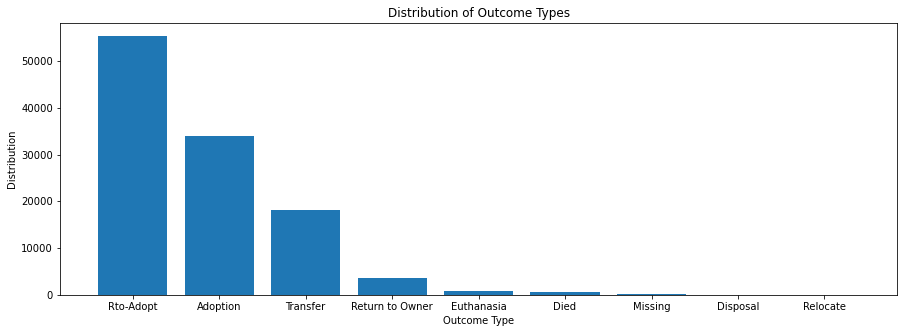

In [30]:
print(outcomes_original['Outcome Type'].value_counts())
fig = plt.figure(figsize = (15, 5)) 
plt.bar(outcomes_original['Outcome Type'].unique(), outcomes_original['Outcome Type'].value_counts().values)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type')
plt.ylabel('Distribution')

In [31]:
# TODO do data exploration with adoption during specific times of the year
indices = (data['Outcome Type'] == 'Disposal')
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

indices = (data['Outcome Type'] == 'Missing')
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

indices = (data['Outcome Type'] == 'Relocate')
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

data['Outcome Type'].unique() # shows that Disposal, Missing, and Relocate have been dropped

array(['Transfer', 'Return to Owner', 'Adoption', 'Euthanasia', 'Died',
       'Rto-Adopt'], dtype=object)

Finally, we will process the categorical features. `Intake Type`, `Intake Condition`, `Animal Type`, `Sex upon Intake`,`Outcome Type`, `Animal Type`, `Sex upon Outcome`, `Breed`, and `Color` are all categorial features. We use one hot encoding on these features so that our classifiers can use them features appropriately. 

In [32]:
continuous_vars = data.select_dtypes(["int64"])
categorical_vars = data.select_dtypes(["object"])
categorical_vars_cols = categorical_vars.columns

one_hot_encoder = OneHotEncoder(sparse=False)
categorical_vars = one_hot_encoder.fit_transform(categorical_vars)
categorical_vars_cols = one_hot_encoder.get_feature_names(categorical_vars_cols)

data = pd.DataFrame(data=categorical_vars, columns=categorical_vars_cols)
data = pd.concat([data, continuous_vars], axis=1)

data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.head()

Intake Type_Abandoned  Intake Type_Euthanasia Request  \
0                    0.0                             0.0   
1                    0.0                             0.0   
2                    0.0                             0.0   
3                    0.0                             0.0   
4                    0.0                             0.0   

   Intake Type_Owner Surrender  Intake Type_Public Assist  Intake Type_Stray  \
0                          0.0                        0.0                1.0   
1                          0.0                        0.0                1.0   
2                          0.0                        0.0                1.0   
3                          0.0                        0.0                1.0   
4                          0.0                        0.0                1.0   

   Intake Type_Wildlife  Intake Condition_Aged  Intake Condition_Behavior  \
0                   0.0                    0.0                        0.0   
1                   0.0                    0.0                        0.0   
2                   0.0                    0.0                        0.0   
3                   0.0                    0.0                        0.0   
4                   0.0                    0.0                        0.0   

   Intake Condition_Feral  Intake Condition_Injured  ...  Outcome Year_2016  \
0                     0.0                       0.0  ...                0.0   
1                     0.0                       0.0  ...                0.0   
2                     0.0                       0.0  ...                1.0   
3                     0.0                       0.0  ...                0.0   
4                     0.0                       0.0  ...                0.0   

   Outcome Year_2017  Outcome Year_2018  Outcome Year_2019  Outcome Year_2020  \
0                0.0                0.0                1.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Outcome Year_2021  Outcome Year_2022  Intake Age (Years)  \
0                0.0                0.0                 2.0   
1                0.0                0.0                 8.0   
2                0.0                0.0                 0.0   
3                0.0                0.0                 0.0   
4                0.0                0.0                 4.0   

   Outcome Age (Years)  Outcome Month  
0                  2.0            1.0  
1                  8.0            7.0  
2                  1.0            4.0  
3                  0.0           10.0  
4                  4.0            7.0  

[5 rows x 3312 columns]

## Data Analysis and Modeling

As a first attemp, we try multi-class classification given our current dataset.

In [58]:
# Helpful method for printing a confusion matrix 
# Credit to Dr. Beasley, who provided us with this
# function in Homework 2
def print_confusion_matrix(mat):
    df = pd.DataFrame(mat, columns = ['Predicted 1', 'Predicted 0'])
    df = df.rename(index={0: 'Acutal 1', 1: 'Actual 0'})
    display(df)

### Multi-Class Classification with AdaBoost

In [452]:
# Create a list of class labels
features = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
labels = np.array([0] * data.shape[0])
label = 1
for feature in features:
    indices = (data[feature] == 1.0) 
    indices = indices.index[indices == True].tolist()
    labels[indices] = label
    label += 1

In [ ]:
# ADAboost multi
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
X = data.drop(drops, axis=1)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])

nested_score = cross_val_score(pipeline, X_train, y_train, cv=5)

    
param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

### Binary Classification with AdaBoost for Adoption

#### Predicting Adoption v. Stray Intake Type

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# TODO rerum

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
holder = data[data['Intake Type_Stray'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])
    
param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search_stray = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search_stray.fit(X_train, y_train)
cv_score_stray = grid_search_stray.best_score_
test_score_stray = grid_search_stray.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_stray}\nTest score: {test_score_stray}')

Cross-validation score: 0.8374854209483308
Test score: 0.8393660973052969


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# TODO run

holder = data[data['Intake Type_Stray'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

preds = cross_val_predict(grid_search_stray, X, y)
mat = confusion_matrix(y, preds)
report = classification_report(y, preds)

print(report)
print_confusion_matrix(mat)

#### Prediction Adoption v. Public Assist Intake Type

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# TODO rerum

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
holder = data[data['Intake Type_Public Assist'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])
    
param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search_public_assist = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search_public_assist.fit(X_train, y_train)
cv_score_public_assist = grid_search_public_assist.best_score_
test_score_public_assist = grid_search_public_assist.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_public_assist}\nTest score: {test_score_public_assist}')

Cross-validation score: 0.8378946234041802
Test score: 0.8288357748650732


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# TODO run

holder = data[data['Intake Type_Public Assist'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

preds = cross_val_predict(grid_search_public_assist, X, y)
mat = confusion_matrix(y, preds)
report = classification_report(y, preds)

print(report)
print_confusion_matrix(mat)

#### Predicting Adoption v. Owner Surrender Intake Type

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# TODO reurn

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
holder = data[data['Intake Type_Owner Surrender'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])

param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search_owner_surrender = GridSearchCV(estimator=pipeline,
                                           param_grid=param_grid,
                                           cv=5)

grid_search_owner_surrender.fit(X_train, y_train)
cv_score_owner_surrender = grid_search_owner_surrender.best_score_
test_score_owner_surrender = grid_search_owner_surrender.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_owner_surrender}\nTest score: {test_score_owner_surrender}')

Cross-validation score: 0.7438386527690114
Test score: 0.7433392539964476


In [69]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# TODO reurn

holder = data[data['Intake Type_Owner Surrender'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

preds = cross_val_predict(grid_search_owner_surrender, X, y)
mat = confusion_matrix(y, preds)
report = classification_report(y, preds)

print(report)
print_confusion_matrix(mat)

KeyboardInterrupt: 

#### Predicting Adoption v. Abandoned Intake Type

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
holder = data[data['Intake Type_Abandoned'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])

param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search_abandoned = GridSearchCV(estimator=pipeline,
                                           param_grid=param_grid,
                                           cv=5)

grid_search_abandoned.fit(X_train, y_train)
cv_score_abandoned = grid_search_abandoned.best_score_
test_score_abandoned = grid_search_abandoned.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_abandoned}\nTest score: {test_score_abandoned}')

Cross-validation score: 0.8317587752053772
Test score: 0.8769230769230769


In [67]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

holder = data[data['Intake Type_Abandoned'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

preds = cross_val_predict(grid_search_abandoned, X, y)
mat = confusion_matrix(y, preds)
report = classification_report(y, preds)

print(report)
print_confusion_matrix(mat)

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79       261
         1.0       0.84      0.89      0.87       386

    accuracy                           0.84       647
   macro avg       0.83      0.82      0.83       647
weighted avg       0.84      0.84      0.83       647



Predicted 1  Predicted 0
Acutal 1          198           63
Actual 0           43          343

#### Predicting Adoption v. Euthanasia Request Intake Type

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
holder = data[data['Intake Type_Euthanasia Request'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=1)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])

param_grid = {
    'smote__k_neighbors': list(range(4,5)),
    'classifier__n_estimators': list(range(150,151)),
}
grid_search_euthanasia_request = GridSearchCV(estimator=pipeline,
                                           param_grid=param_grid,
                                           cv=5)

grid_search_euthanasia_request.fit(X_train, y_train)
cv_score_euthanasia_request = grid_search_euthanasia_request.best_score_
test_score_euthanasia_request = grid_search_euthanasia_request.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_euthanasia_request}\nTest score: {test_score_euthanasia_request}')

Cross-validation score: 0.9506006006006006
Test score: 0.9130434782608695


In [66]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

holder = data[data['Intake Type_Euthanasia Request'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

preds = cross_val_predict(grid_search_euthanasia_request, X, y)
mat = confusion_matrix(y, preds)
report = classification_report(y, preds)

print(report)
print_confusion_matrix(mat)

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       218
         1.0       0.00      0.00      0.00        10

    accuracy                           0.94       228
   macro avg       0.48      0.49      0.48       228
weighted avg       0.91      0.94      0.93       228



Predicted 1  Predicted 0
Acutal 1          214            4
Actual 0           10            0

#### Predicting Adoption v. Wildlife Intake Type

As mentioned in the data exploration section, we unfortunately do not have enough data for Wildlafe Intake Type to relate it to adoption patterns. Hence, the model for this relationship could not be created (in fact, when we tried to, the model complained that there wasn't enought data for it to work with).

# TODO do this EDA as well

### Binary Classification with AdaBoost for Rto-Adoption

In [71]:
outcomes_original['Outcome Type'].unique()

array(['Rto-Adopt', 'Adoption', 'Transfer', 'Return to Owner',
       'Euthanasia', 'Died', 'Missing', 'Disposal', 'Relocate'],
      dtype=object)

#### Predicting Rto-Adoption v. Stray Intake Type

In [82]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt']
holder = data[data['Intake Type_Stray'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Rto-Adopt']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['classifier', AdaBoostClassifier()]])
    
param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search_stray = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search_stray.fit(X_train, y_train)
cv_score_stray = grid_search_stray.best_score_
test_score_stray = grid_search_stray.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_stray}\nTest score: {test_score_stray}')

Cross-validation score: 0.9908891848767591
Test score: 0.9914287476105321


In [83]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

holder = data[data['Intake Type_Stray'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Rto-Adopt']

preds = cross_val_predict(grid_search_stray, X, y)
mat = confusion_matrix(y, preds)
report = classification_report(y, preds)

print(report)
print_confusion_matrix(mat)

KeyboardInterrupt: 

### SVM

In [55]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import cross_val_predict

# scaler = StandardScaler()
# pca = PCA()
# svc = SVC()

# # data_copy = data.copy()
# # data_copy.sample(frac=1).reset_index(drop=True)
# # features, labels = data_copy.drop('Outcome Type', axis=1)[:18000], data_copy['Outcome Type'][:18000]

# # pipeline = Pipeline(steps=[('scaling', scaler), ('svc', svc)])
# # param_grid = {
# #     # 'pca__n_components': [5],
# #     'svc__kernel': ['linear']
# # }
# # grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# # predictions = cross_val_predict(grid_search, features, labels, cv=5)

# # print(accuracy_score(labels, predictions))
# # print(classification_report(labels, predictions))

# # print(accuracy_score(labels, predictions))
# # print(classification_report(labels, predictions))
# p = Pipeline([('scaler', scaler), ('pca', pca), ('svc', svc)])
# param_grid = {
#     'pca__n_components': [5],
#     'svc__kernel': ['linear', 'rbf', 'poly']
# }
# search = GridSearchCV(p, param_grid, cv=5)
# search.fit(features, labels)
# preds = cross_val_predict(search, features, labels, cv=5)
# print(classification_report(labels, preds))

## Decision Trees Nested Cross Validation

In [56]:
# Try out some classification approaches, with outcome type as the label
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy')
grid_params = {
    'max_depth': [5, 8, 13], 
    'min_samples_leaf': [5, 10, 15, 20], 
    'max_features': list(range(1, 12))
}
grid_search = GridSearchCV(decision_tree, grid_params, cv=5, scoring='accuracy')
grid_search.fit(features, labels)

print('Best values: ', grid_search.best_params_)
print('Accuracy:', grid_search.best_score_*100)

Best values:  {'max_depth': 13, 'max_features': 9, 'min_samples_leaf': 20}
Accuracy: 73.87708084386988


## k-Nearest Neighbor (KNN)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

std = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier(n_neighbors=7)
p = Pipeline([('scaler', std), ('pca', pca), ('knn', knn)])
nested_score = cross_val_score(p, features, labels, cv=5)


param_grid = {
    'pca__n_components': list(range(5, 12)),
    'knn__n_neighbors': list(range(1, 25))
}

# your code goes here
search = GridSearchCV(p, param_grid, cv=5)
search.fit(features, labels)
print(search.best_params_)
print("Accuracy:", search.best_score_*100)

{'knn__n_neighbors': 22, 'pca__n_components': 11}
Accuracy: 72.15337318984646


## Naive Bayes (NB) & Evaluation Metrics

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
clf = GaussianNB()
nested_score = cross_val_score(clf, features, labels, cv=10)

preds = cross_val_predict(clf, features, labels)
# print(preds)
mat = confusion_matrix(labels, preds)
print(mat)
print(classification_report(labels, preds))

[[    6   446     7    36   169     0     0     0     1]
 [  207 39141   708  8599  5819   101    80    20   344]
 [   23   966  1108  1685   989    16  4061     0    53]
 [  125 19547   685 13474  3736   177   222    21   207]
 [   91  8952   209   962  7942    39    16     2    79]
 [    3   393    72   541   109     0   139     2    11]
 [    2    38    99    82    12     3   383     0     5]
 [    0    32     0    24     2     0     2     0     0]
 [    0     3     6     1     0     0     8     0     6]]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       665
           1       0.56      0.71      0.63     55019
           2       0.38      0.12      0.19      8901
           3       0.53      0.35      0.42     38194
           4       0.42      0.43      0.43     18292
           5       0.00      0.00      0.00      1270
           6       0.08      0.61      0.14       624
           7       0.00      0.00      0.00        60

In [59]:
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import cross_val_predict

# predictions = cross_val_predict(grid_search, data.drop('Outcome Type', axis=1), data['Outcome Type'])
# print(confusion_matrix(data['Outcome Type'], predictions))